In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.utils import to_scipy_sparse_matrix
import scipy
from torch_geometric.datasets import Planetoid, TUDataset, QM9
from scipy.sparse.csgraph import floyd_warshall, dijkstra
import seaborn as sns
import igraph

In [13]:
mutagenity_feature_names = list({
    0: 'C', 1: 'O', 2: 'Cl', 3: 'H', 4: 'N', 5: 'F', 6: 'Br',
    7: 'S', 8: 'P', 9: 'I', 10: 'Na', 11: 'K', 12: 'Li', 13: 'Ca'
}.values())

In [14]:
# Use the repo model that was actually trained/saved
from models import TensorGNAN as GNAN

In [15]:
data_path = 'data'
dataset = TUDataset(root=data_path, name='Mutagenicity')
data = list(dataset)

num_classes = dataset.num_classes
num_features = data[0].x.size(-1)

mutagenicity_gnan = "models/dropout09_best_val_acc.pt"

# IMPORTANT: TensorGNAN uses n_layers (not num_layers) and your checkpoint was saved with bias=False
model = GNAN(
    in_channels=num_features,
    hidden_channels=64,
    n_layers=3,
    out_channels=1,
    dropout=0.0,      # doesn’t affect loaded weights at eval time
    bias=False,       # <<< matches checkpoint (avoids missing bias keys in rho)
    rho_per_feature=0 # <<< matches your training config
)

# Load weights
state = torch.load(mutagenicity_gnan, map_location='cpu')
missing, unexpected = model.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
model.eval()

# diameter for plotting
max_distance = 0
for g in data:
    igraph_graph = igraph.Graph(directed=False)
    igraph_graph.add_vertices(g.x.size(0))
    # igraph expects list of (u,v) tuples
    igraph_graph.add_edges(list(map(tuple, g.edge_index.T.cpu().numpy())))
    curr_max_distance = igraph_graph.diameter(directed=False)
    if curr_max_distance > max_distance:
        max_distance = curr_max_distance

Missing keys: ['rho.0.bias', 'rho.2.bias', 'rho.4.bias']
Unexpected keys: ['fs.14.0.weight', 'fs.14.0.bias', 'fs.14.3.weight', 'fs.14.3.bias', 'fs.14.6.weight', 'fs.14.6.bias', 'fs.0.0.bias', 'fs.0.3.bias', 'fs.0.6.bias', 'fs.1.0.bias', 'fs.1.3.bias', 'fs.1.6.bias', 'fs.2.0.bias', 'fs.2.3.bias', 'fs.2.6.bias', 'fs.3.0.bias', 'fs.3.3.bias', 'fs.3.6.bias', 'fs.4.0.bias', 'fs.4.3.bias', 'fs.4.6.bias', 'fs.5.0.bias', 'fs.5.3.bias', 'fs.5.6.bias', 'fs.6.0.bias', 'fs.6.3.bias', 'fs.6.6.bias', 'fs.7.0.bias', 'fs.7.3.bias', 'fs.7.6.bias', 'fs.8.0.bias', 'fs.8.3.bias', 'fs.8.6.bias', 'fs.9.0.bias', 'fs.9.3.bias', 'fs.9.6.bias', 'fs.10.0.bias', 'fs.10.3.bias', 'fs.10.6.bias', 'fs.11.0.bias', 'fs.11.3.bias', 'fs.11.6.bias', 'fs.12.0.bias', 'fs.12.3.bias', 'fs.12.6.bias', 'fs.13.0.bias', 'fs.13.3.bias', 'fs.13.6.bias']


In [16]:
# Plot rho in normalized distances (1 / (1 + d))
x_ticks = [i for i in range(max_distance + 1)]
y_input_values = torch.tensor([1/(1+i) for i in x_ticks], dtype=torch.float32).view(-1, 1)

with torch.no_grad():
    m_y_values = model.rho(y_input_values).view(-1).cpu().numpy()

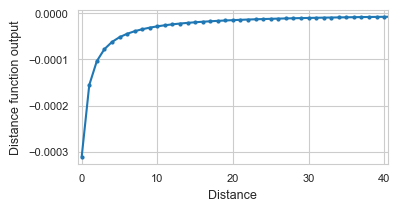

In [17]:
# plot for distance function
sns.set_style("whitegrid")
plt.figure(figsize=(4, 2))

x_ticks = [i for i in range(max_distance+1)]

#remove the paddings in the beggining and end of the plot
plt.xlim(-0.5, max_distance-0.5)
plt.plot(x_ticks, m_y_values, marker='.', markersize=4)
# plt.xticks(distance_ticks)
plt.xlabel('Distance', size=9)
plt.ylabel('Distance function output', size=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

In [18]:
f_scores = torch.zeros((num_features, ))
for i in range(num_features):
    f_scores[i] = model.fs[i].forward(torch.tensor([1.0]).view(-1, 1)).detach().flatten()[0]

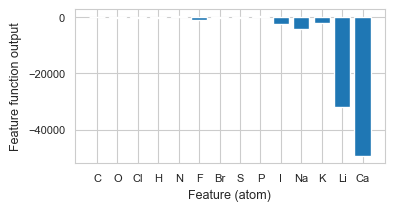

In [19]:
# Make labels exactly num_features long
if len(mutagenity_feature_names) < num_features:
    feat_labels = mutagenity_feature_names + [f'feat_{i}' for i in range(len(mutagenity_feature_names), num_features)]
else:
    feat_labels = mutagenity_feature_names[:num_features]

# plot a bar plot of the f_scores with the feature names
plt.figure(figsize=(4, 2))
plt.bar(feat_labels, f_scores.cpu().numpy())
plt.xlabel('Feature (atom)', size=9)
plt.ylabel('Feature function output', size=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [20]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["red", "white", "green"]  # Red to white to green
n_bins = 100  # Number of bins in the colormap
cmap_name = "custom_colormap"
# Create the colormap
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
plot_x = torch.tensor(np.arange(max_distance)).long()
plot_y = torch.zeros((len(f_scores), 1))


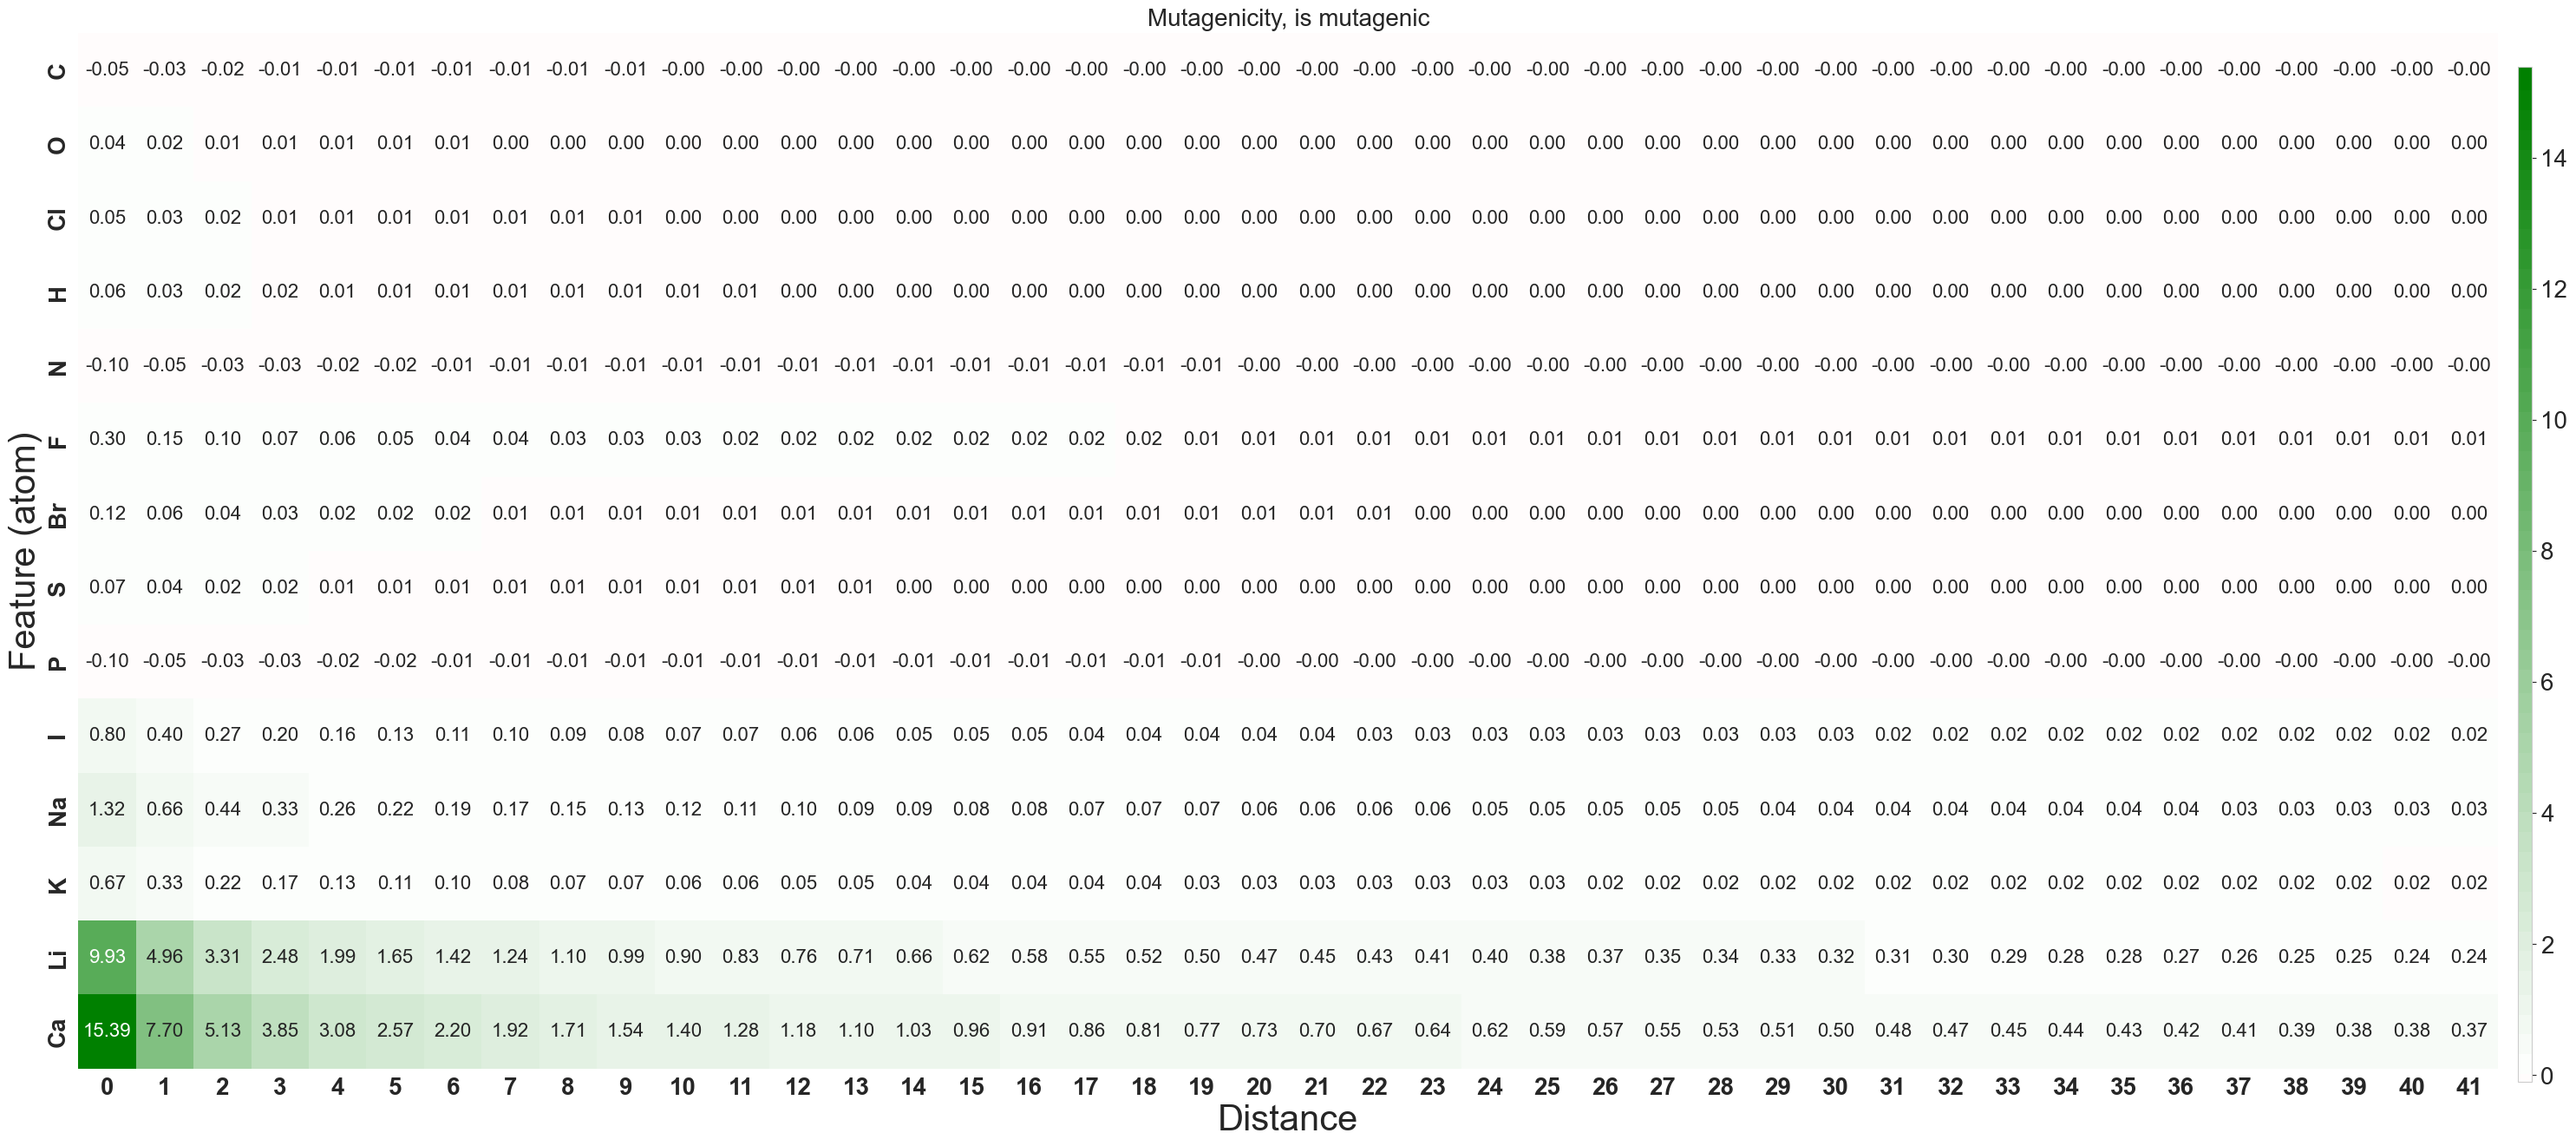

In [21]:
# heatmap z = f(feature) ⊗ rho(distance)
z = np.outer(f_scores.cpu().numpy(), m_y_values)

fig, ax= plt.subplots(figsize=(45, 15.5))
sns.heatmap(
    z, annot=True, fmt=".2f",
    xticklabels=x_ticks, yticklabels=feat_labels,
    cmap=cmap, center=0, annot_kws={"fontsize":16}, cbar=False, ax=ax
)
cbar = plt.colorbar(ax.collections[0], ax=ax, use_gridspec=True, aspect=70)
cbar.ax.set_position([0.75, 0.1, 2, 0.755])
cbar.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight='bold')
plt.xlabel('Distance', size=30)
plt.ylabel('Feature (atom)', size=30)
plt.title('Mutagenicity, is mutagenic', size=20)
plt.show()